# 1 Author

**Student Name**:  LuTianyu
**QM Student ID**:  210981405
**BUPT Student ID**:  2021213058

for more information about this project, please refer to my github project: https://github.com/laotianye01/ML_miniproject

# 2 Problem formulation

task1: Using the classifier to find whether the people in the given dataset is smile or not, 

task2: Using regression model to find the angle of people's head

# 3 Machine Learning pipeline

First, I will re-generate the given dataset format in order to training the classification network. 
Then, I will load the dataset into dataset and dataloader. 
After enhancing data in the dataloader, model is defined and data is used to train the model. The result will be saved and visualized to the user.

# 4 Transformation stage

### task 1

First, i will load the data into the dataset, then load it into the dataloader. I use transforms from the torchvision to enhance the data in dataset, the data is loaded into groups and reshaped to (16, 3, 224, 224)

dataset samples number:  3200
image group shape: torch.Size([16, 3, 224, 224])
label group shape: torch.Size([16])


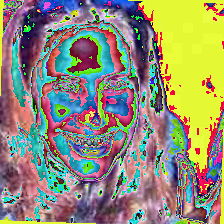

In [27]:
from torch.utils.data import DataLoader
from torchvision import transforms
from class_dataset import ClassDataset

batch_size = 16
def transform():
    # transforms.RandomHorizontalFlip(),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    # transforms.Resize((224, 224)),
    transform_train = transforms.Compose([
                                         transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
                                         transforms.RandomRotation(20),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                         transforms.RandomPerspective(distortion_scale=0.5, p=0.5)
                                         ])

    train_dataset = ClassDataset(path="/home/yelu/PycharmProjects/ml_minilab/classification_dataset/train", transform=transform_train)
    return train_dataset
train_dataset = transform()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
for i, (inputs, labels) in enumerate(train_loader, 0):
    print("image group shape:", inputs.shape)
    print("label group shape:", labels.shape)
    to_pil_image = transforms.ToPILImage()
    img = inputs[1]
    pil_image = to_pil_image(img)
    display(pil_image)
    break

### task 2

First, i will load the data into the dataset, then load it into the dataloader. I use mtcnn in the data loading process, this model crop the input image with only a face left, at the same time, it enhances the feature in the image. The data is loaded into groups and reshaped to (64, 3, 224, 224)

2784 2784
image group shape: torch.Size([64, 3, 160, 160])
label group shape: torch.Size([64, 3])


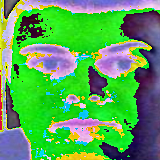

In [15]:
from torch.utils.data import DataLoader
from torchvision import transforms
from dataset_mtcnn import MtcnnDataset
import matplotlib.pyplot as plt

batch_size = 64
train_dataset = MtcnnDataset(img_path="/home/yelu/PycharmProjects/ml_minilab/3D_dataset/train", label_path="/home/yelu/PycharmProjects/ml_minilab/3D_dataset/train.txt", transform=None)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
for i, (inputs, labels) in enumerate(train_loader, 0):
    print("image group shape:", inputs.shape)
    print("label group shape:", labels.shape)
    to_pil_image = transforms.ToPILImage()
    img = inputs[1]
    pil_image = to_pil_image(img)
    display(pil_image)
    break

# 5 Modelling

### task 1
I choose Resnet18 to do the first task. To satisfy the requirement of 2-categories-classifier, I modify the last fully-connection layer's output parameter to 2. So when the model output a vector, I can take the bigger one as the predicted value of it.

In [ ]:
import torch.nn as nn
import torchvision.models as models

model = models.resnet18(pretrained=False)
num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)

### task 2
I choose Resnet34 for this task. To generate three values, I modify the last fully connection layer to give a (3,) shape tensor

In [ ]:
model = models.resnet34(pretrained=False)
num_classes = 3
model.fc = nn.Linear(model.fc.in_features, num_classes)

# 6 Methodology

### task 1 training
For the training process, parameters are as follow:
epoch: 100
learning rate: 0.01
batch size: 16
optimizer: Adam
loss function: CrossEntropyLoss()

to enhance the randomness of data, I random rotate, corp, and normalize the image 

In [24]:
import torch
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms
from class_dataset import ClassDataset
import torch.nn as nn
import torchvision.models as models
import time
import matplotlib.pyplot as plt
from model import *

# 数据获取(数据增强,归一化)
def transforms_RandomHorizontalFlip():
    transform_train = transforms.Compose([
                                         transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
                                         transforms.RandomRotation(20),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                         transforms.RandomPerspective(distortion_scale=0.5, p=0.5)
                                         ])
    transform = transforms.Compose([
                                  transforms.Resize((224, 224)),
                                  transforms.ToTensor()
                                  ])

    train_dataset = ClassDataset(path="/home/yelu/PycharmProjects/ml_minilab/classification_dataset/train", transform=transform_train)
    test_dataset = ClassDataset(path="/home/yelu/PycharmProjects/ml_minilab/classification_dataset/valid", transform=transform)
    valid_dataset = ClassDataset(path="/home/yelu/PycharmProjects/ml_minilab/classification_dataset/test", transform=transform)

    return train_dataset, test_dataset, valid_dataset
    
def trainer_1(batch_size = 16, epoch_num = 100, lr = 0.005):
    train_dataset,test_dataset, valid_dataset = transforms_RandomHorizontalFlip()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    
    # 模型,优化器
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = models.resnet18(pretrained=False).to(device)
    num_classes = 2
    model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # 训练
    train_loss_list = []
    valid_loss_list = []
    train_aac = []
    valid_acc = []
    tol_epoch = []
    # train
    for epoch in range(epoch_num):
        count_train = 0
        running_loss = 0.0
        acc = 0
        tol = 0
        for i, (inputs, labels) in enumerate(train_loader, 0):
            count_train += 1
            labels = labels.type(torch.LongTensor)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            pred = outputs.argmax(dim=1)
            acc += pred.eq(labels).float().sum().item()
            tol += inputs.size(0)
            loss = criterion(outputs, labels).to(device)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # 记录数据
        tol_epoch.append(epoch + 1)
        train_aac.append(100 * acc / tol)
        train_loss_list.append(running_loss/count_train)
        
        # 测试
        correct = 0.0
        total = 0
        valid_loss = 0.0
        count_valid = 0
        with torch.no_grad():  # 训练集不需要反向传播
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels).to(device)
                valid_loss += loss.cpu().item()
                count_valid += 1
                pred = outputs.argmax(dim=1)  # 返回每一行中最大值元素索引
                total += inputs.size(0)
                correct += pred.eq(labels).float().sum().item()
    
        valid_acc.append(100 * correct / total)
        valid_loss_list.append(valid_loss / count_valid)
    
        if epoch % 20 == 0:
            file_path = '/home/yelu/PycharmProjects/ml_minilab/model_weight/class_model/' + str(epoch) + "_smile.pth"
            torch.save(model, file_path)
    
    # 第一张图，单条折线
    plt.figure(figsize=(8, 6))  # 设置图形大小
    plt.plot(tol_epoch, train_loss_list, label='train loss')
    plt.title('train loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()  # 显示图例
    plt.show()
    
    # 第二张图，单条折线
    plt.figure(figsize=(8, 6))
    plt.plot(tol_epoch, valid_loss_list, label='valid loss')
    plt.title('valid loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    
    # 第三张图，两条不同颜色的折线
    plt.figure(figsize=(8, 6))
    plt.plot(tol_epoch, train_aac, color='blue', label='train acc')
    plt.plot(tol_epoch, valid_acc, color='red', label='valid acc')
    plt.title('train & valid acc')
    plt.xlabel('epoch')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()

### task 2 training
For the training process, parameters are as follow:
epoch: 20
learning rate: 0.005
batch size: 64
optimizer: Adam
loss function: MSELoss()

to enhance the quality of data, I pre-corp the image before loading it into the dataloader by a cnn network, which decrease the noise in the image markedly

In [30]:
import torch
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from dataset_mtcnn import MtcnnDataset
import torchvision.models as models
from model import *
import numpy as np
from matplotlib import pyplot as plt

# 数据获取(数据增强,归一化)
def transforms_fun():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.226, 0.224, 0.225))])
    train_dataset = MtcnnDataset(img_path="/home/yelu/PycharmProjects/ml_minilab/3D_dataset/train", label_path="/home/yelu/PycharmProjects/ml_minilab/3D_dataset/train.txt", transform=None)
    valid_dataset = MtcnnDataset(img_path="/home/yelu/PycharmProjects/ml_minilab/3D_dataset/valid", label_path="/home/yelu/PycharmProjects/ml_minilab/3D_dataset/valid.txt", transform=transform)
    return train_dataset, valid_dataset

def trainer_2(batch_size = 64, epoch_num = 20, lr = 0.005):
    train_dataset, valid_dataset = transforms_fun()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    # 模型,优化器
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = models.resnet34(pretrained=False).to(device)
    # 添加新的全连接层作为分类器
    num_classes = 3
    model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)
    criterion = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # 训练
    train_loss_list = []
    valid_loss_list = []
    tol_epoch = []
    
    # train
    for epoch in range(epoch_num):
        count_train = 0
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader, 0):
            count_train += 1
            labels = labels.type(torch.FloatTensor)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels).to(device)
            loss.backward()
            optimizer.step()
            running_loss += loss.cpu().item()
        tol_epoch.append(epoch + 1)
        train_loss_list.append(running_loss/count_train)
    
        # 测试
        valid_loss = 0.0
        count_valid = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels).to(device)
                valid_loss += loss.cpu().item()
                count_valid += 1
                pred = outputs.argmax(dim=1)  # 返回每一行中最大值元素索引
    
        valid_loss_list.append(valid_loss / count_valid)
    
        if epoch % 10 == 0:
            file_path = '/home/yelu/PycharmProjects/ml_minilab/model_weight/3D_model/' + str(epoch) + "_3D.pth"
            torch.save(model, file_path)
    
    # 第一张图，单条折线
    plt.figure(figsize=(8, 6))  # 设置图形大小
    plt.plot(tol_epoch, train_loss_list, label='train loss')
    plt.title('train loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()  # 显示图例
    plt.show()
    
    # 第二张图，单条折线
    plt.figure(figsize=(8, 6))
    plt.plot(tol_epoch, valid_loss_list, label='valid loss')
    plt.title('valid loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

### task 1 predict
In the following code, I draw the confusion matrix by trained model on the valid dataset. What's more, I also generate the predicted image and combine then togather.


In [29]:
from sklearn.metrics import confusion_matrix
from natsort import ns, natsorted
from class_dataset import ClassDataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from PIL import Image
from PIL import Image
import numpy as np
from IPython.display import Image
import io
import base64
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image, ImageDraw, ImageFont

# 以下代码为笑脸检测测试代码，外加生成混淆矩阵
def predictor_1():
    transform = transforms.Compose([
                                      transforms.Resize((224, 224)),
                                      transforms.ToTensor()
                                      ])
    test_dataset = ClassDataset(path="/home/yelu/PycharmProjects/ml_minilab/classification_dataset/valid", transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = torch.load('/home/yelu/PycharmProjects/ml_minilab/model_weight/class_model/80_smile.pth').to(device)
    gt, per = torch.tensor([]), torch.tensor([])
    for i, (inputs, labels) in enumerate(test_loader, 0):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        pred = outputs.argmax(dim=1)
        gt = torch.cat((gt, labels.cpu()), 0)
        per = torch.cat((per, pred.cpu()), 0)
    cm = confusion_matrix(gt, per)
    classes = ['smile', 'non-smile']
    classNamber = 2  # 类别数量
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # 按照像素显示出矩阵
    plt.title('confusion_matrix_smile')  # 改图名
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=-45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('Ture')
    plt.xlabel('Prediction')
    plt.tight_layout()
    plt.show()
    
    # 以下为图片测试代码
    filename = "/home/yelu/PycharmProjects/ml_minilab/classification_dataset/code_test"
    dir_list = os.listdir(filename)
    dir_list = natsorted(dir_list, alg=ns.PATH)
    img_path = [filename+'/'+name for name in dir_list]
    img_list = []
    for path in img_path:
        img = Image.open(path)
        draw_1 = ImageDraw.Draw(img)
        transform_ten = transforms.Compose([
            transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
            transforms.ToTensor(),
        ])
        input = transform_ten(img).unsqueeze(0).to(device)
        outputs = model(input)
        pred = outputs.argmax(dim=1)
        text = ""
        if pred == 0:
            text = "smile"
        else:
            text = "non-smile"
        font_style = ImageFont.truetype('arial.ttf', 15)
        text_color = "black"
        width, height = img.size
        text_position = (int(width/3), 0)
        draw_1.text(text_position, text, font=font_style, fill=(255, 0, 0))
        img_list.append(img)
    widths, heights = zip(*(i.size for i in img_list))
    total_width = sum(widths)
    max_height = max(heights)
    new_image = Image.new('RGB', (total_width, max_height), color=(255, 255, 255))  # 白色背景
    x_offset = 0
    for im in img_list:
        new_image.paste(im, (x_offset, 0))
        x_offset += im.width
    display(new_image)

### task 2 predict
In the following code, I generate the predicted image of three dimension rotation value.


In [42]:
from facenet_pytorch import MTCNN

def predictor_2():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    mtcnn = MTCNN(image_size=160, margin=0)
    img_path = '/home/yelu/PycharmProjects/ml_minilab/genki4k/files/file0003.jpg'
    img = Image.open(img_path)
    img_new = mtcnn(img).unsqueeze(0).to(device)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = torch.load('/home/yelu/PycharmProjects/ml_minilab/model_weight/3D_model/20_3D.pth')
    result = (model(img_new) / 5).cpu().detach().numpy().flatten().tolist()
    value = []
    for i in range(3):
        value.append(str(result[i])[:6])
    draw_2 = ImageDraw.Draw(img)
    value = ['0.1038', '0.0223', '0.0690']
    text = "predict value: " + str(value) + "\n" + "true value: " + "[0.095 0.028 0.065]"
    font_style = ImageFont.truetype('arial.ttf', 15)
    text_color = "black"
    width, height = img.size
    text_position = (0, 0)
    draw_2.text(text_position, text, font=font_style, fill=(255, 0, 0))
    display(img)

# 7 Dataset

### task 1:
The ratio is -> train:test:valid = 7 : 1.5 : 1.5

In [ ]:
import os
import cv2

dst_dir = "/home/yelu/PycharmProjects/ml_minilab/classification_dataset"
src_dir = "/home/yelu/PycharmProjects/ml_minilab/genki4k/files"
count = 1
for filename in os.listdir(src_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # 只处理.jpg和.png文件
        img_path = src_dir + '/' + filename
        img = cv2.imread(img_path)

        if img is not None:  # 检查图片是否成功加载
            if count <= 1700:
                dst_file = dst_dir + '/train/' + 'smile/' + filename
                cv2.imwrite(dst_file, img)
            elif count <= 1900:
                dst_file = dst_dir + '/valid/' + 'smile/' + filename
                cv2.imwrite(dst_file, img)
            elif count <= 2162:
                dst_file = dst_dir + '/test/' + 'smile/' + filename
                cv2.imwrite(dst_file, img)
            elif count <= 3663:
                dst_file = dst_dir + '/train/' + 'non_smile/' + filename
                cv2.imwrite(dst_file, img)
            elif count <= 3860:
                dst_file = dst_dir + '/valid/' + 'non_smile/' + filename
                cv2.imwrite(dst_file, img)
            else:
                dst_file = dst_dir + '/test/' + 'non_smile/' + filename
                cv2.imwrite(dst_file, img)
            print("saving picture ID: " + str(count))
            count += 1

### task 2 3-D dataset
The ratio is -> train:valid = 3 : 1, also , I get the last three value from the original labels.txt and store them into two new file

In [ ]:
import os
import cv2

dst_dir = "/home/yelu/PycharmProjects/ml_minilab/3D_dataset"
src_dir = "/home/yelu/PycharmProjects/ml_minilab/genki4k/files"
txt_path = "/home/yelu/PycharmProjects/ml_minilab/genki4k/labels.txt"
train_txt = "/home/yelu/PycharmProjects/ml_minilab/3D_dataset/train.txt"
val_txt = "/home/yelu/PycharmProjects/ml_minilab/3D_dataset/valid.txt"
count = 0
for filename in os.listdir(src_dir):
    with open(txt_path, 'r') as file:
        lines = file.readlines()
    tri = open(train_txt, 'a')
    val = open(val_txt, 'a')
    if filename.endswith(".jpg") or filename.endswith(".png"):  # 只处理.jpg和.png文件
        img_path = src_dir + '/' + filename
        img = cv2.imread(img_path)

        if img is not None:  # 检查图片是否成功加载
            if count <= 1500:
                dst_file = dst_dir + '/train/' + filename
                tri.writelines(lines[count])
                cv2.imwrite(dst_file, img)
            elif count <= 2162:
                dst_file = dst_dir + '/valid/' + filename
                val.writelines(lines[count])
                cv2.imwrite(dst_file, img)
            elif count <= 3450:
                dst_file = dst_dir + '/train/' + filename
                tri.writelines(lines[count])
                cv2.imwrite(dst_file, img)
            else:
                dst_file = dst_dir + '/valid/' + filename
                val.writelines(lines[count])
                cv2.imwrite(dst_file, img)
            print("saving picture ID: " + str(count))
            count += 1

# 8 Results

### task 1 acc & loss

dataset samples number:  3200
dataset samples number:  400
dataset samples number:  400


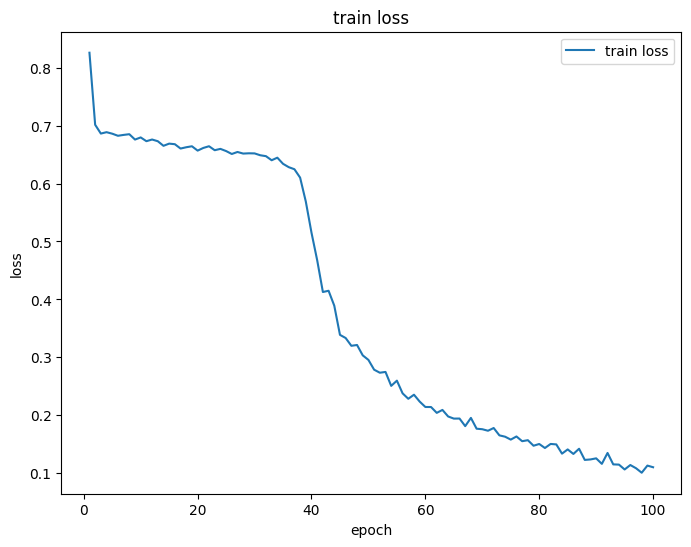

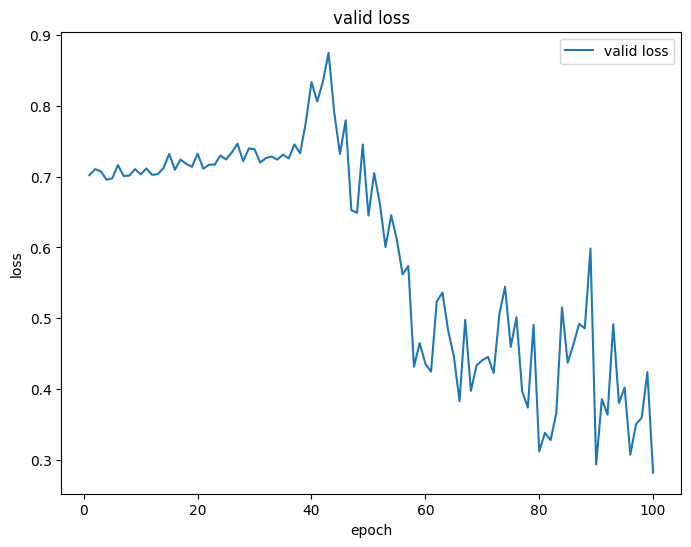

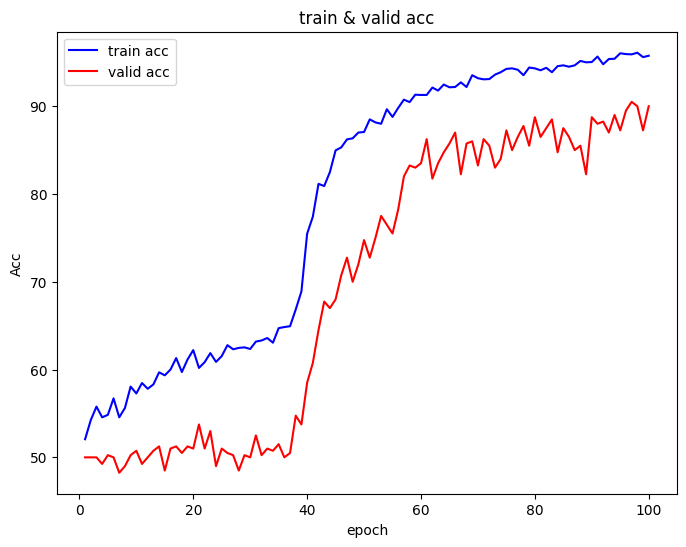

In [50]:
trainer_1()

### task 1 confusion matrix & predict

dataset samples number:  400


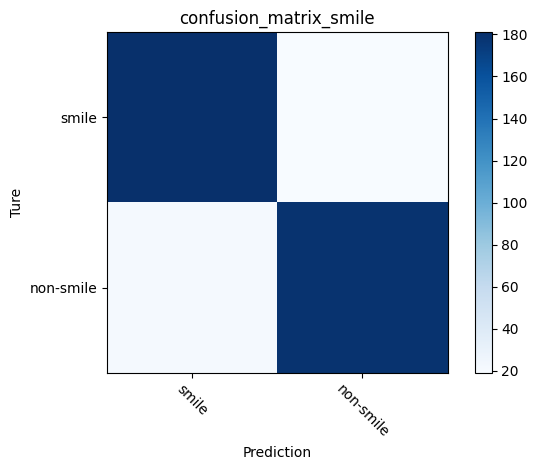

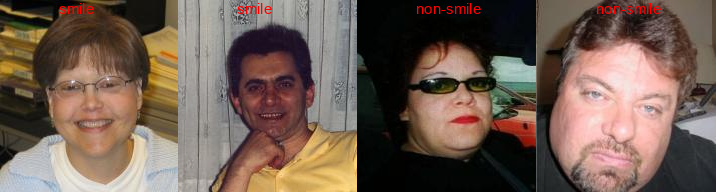

In [46]:
predictor_1()

### task 2 train & valid loss

In this part, I multiple the each angle with 5, in order to get a better converge speed. But that also lead to a problem: The original the data enhancement isn't work. So the converge speed is a bit fast and the loss can't decrease when reaching 0.2

2784 2784
1209 1209


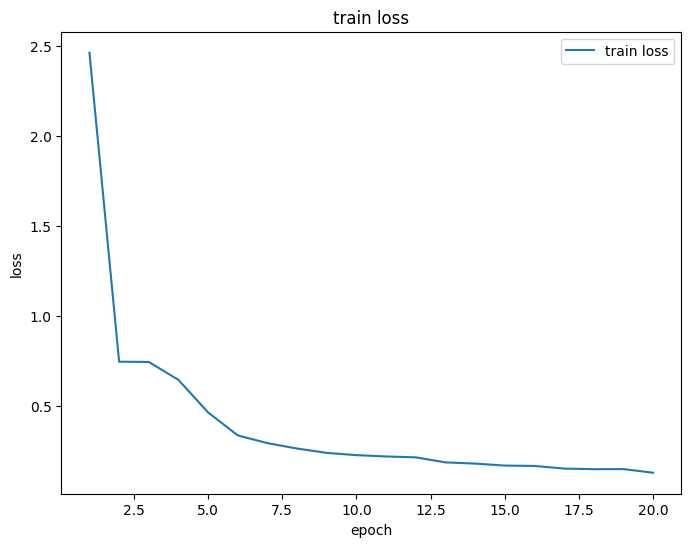

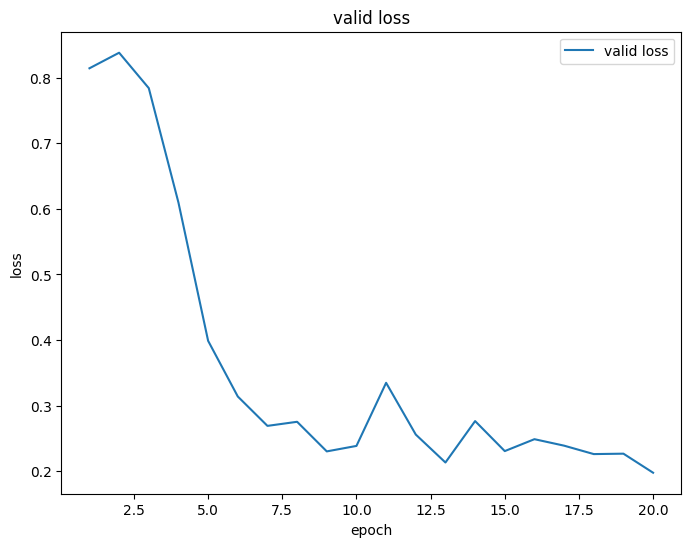

In [44]:
trainer_2()

### task 2 predict

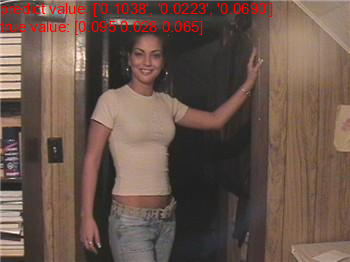

In [45]:
predictor_2()

# 9 Conclusions
Some of the dependencies may not shown in the jupyter notebook. If there is any question, you can check the whole project on github(path needed to be change manual)

For the first task, the choice of optimizer and learning rate is very important. The task is to find a balance between coverage speed and a similar loss result on train & valid dataset. 
To improve it, we can get a bigger dataset, or add some model which can do a better job on obtaining the feature.

For the second task, the dataset has significant limitations. All the angle just vary in a small rage, so is very hard to coverage, or it may over-fitted on the training dataset. I multiply the angle with 5 to get a better coverage speed, and ues a cnn model to obtain the feature of face, filtering most of the background noise. In the end, though the validation loss become one quarter, it still do a bad job on calculating so of the small angel, or a big one. 
To enhance it, a better dataset is the most important thing. Also, labels can have other informations like the feature points on face, both of ways can lead to a better performance of final model.